# Config and Imports

In [1]:
import os
os.chdir('../../')
prj_path = "./data/IGs/"
print(os.getcwd())

c:\Users\andri\Progetti\igraph_transformer


In [2]:
import random

import torch
import pickle
import torch.utils.data
import time
import os


import networkx as nx

%matplotlib inline

from data.IGs import IGsDatasetDGL

Using backend: pytorch


# Prepare dataset

txt --> train/test/val PKL: NO DGL

In [3]:
data_list = []
dataset = []

#data_path = prj_path + 'ig_subgraphs.txt'
with open(prj_path + 'ig_subgraphs.txt', 'r') as file:
    for line in file:
        line = line.strip()  # Remove whitespace and newline characters
        values = line.split(']')  # Split the line based on the ']' character
        nums = values[0].strip('[, ')  # Extract the numbers inside the square brackets
        nums = [int(num) for num in nums.split(',')]  # Convert the numbers into a list of integers
        num_after_bracket = int(values[1].strip())  # Extract the number after the square bracket
        data_list.append([nums, num_after_bracket])

random.shuffle(data_list)

G = nx.Graph()

for data in data_list:
  nodes, label = data[:2]
  edges = [(nodes[i], nodes[i+1]) for i in range(len(nodes)-1)]

  G.clear()  # Svuota il grafo precedente
  G.add_nodes_from(nodes)
  G.add_edges_from(edges)

  obj = (G.copy(), int(label))
  dataset.append(obj)
  
with open(prj_path + 'igraph-GTN.pkl', 'wb') as f:
  pickle.dump(dataset, f)

In [4]:
# dataset = [data for data in dataset if data[1] != 15]
len(dataset)

13811

### Split and Dump train,val,test pkl

In [5]:
from torch.utils.data import Subset
from sklearn.model_selection import StratifiedKFold,StratifiedShuffleSplit

import random
import torch
import numpy as np

from collections import defaultdict

#-------------------------------TRAIN/TEST/VAL SPLIT-----------------------------
seed = 10
random.seed(seed)
torch.manual_seed(seed)

train_p = 0.80  # Train set percentage
test_p = 0.15  # Test set percentage

num_samples_train = int(train_p * len(dataset))
# Use StratifiedKFold to split the data into train and test sets stratifically
sss_train_test = StratifiedShuffleSplit(n_splits=1, train_size=num_samples_train, random_state=seed)

# Get the data and targets from the dataset
data = [sample[0] for sample in dataset]
targets = [sample[1] for sample in dataset]

# Convert data and targets to numpy arrays
data = np.array(data)
targets = np.array(targets)

for train_index, test_index in sss_train_test.split(data, targets):
    # Split the data into train and test sets
    data_train, data_test = data[train_index], data[test_index]
    targets_train, targets_test = targets[train_index], targets[test_index]
print(f"Train set size: {len(data_train)}\nTest set size: {len(data_test)}")

Train set size: 11048
Test set size: 2763


Total samples in dataset: 11048
class 7: 2062 samples
class 10: 2156 samples
class 9: 1619 samples
class 15: 43 samples
class 14: 3069 samples
class 5: 414 samples
class 8: 391 samples
class 6: 319 samples
class 11: 349 samples
class 3: 53 samples
class 12: 458 samples
class 13: 43 samples
class 4: 62 samples
class 2: 10 samples


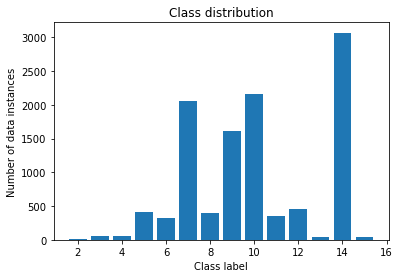

In [6]:
import matplotlib.pyplot as plt
from collections import defaultdict

train = Subset(dataset, train_index)
test = Subset(dataset, test_index)


plt_ds = train

print(f"Total samples in dataset: {len(plt_ds)}")
# Count number of data instances in each class for test set
class_counts = defaultdict(int)
for i, data in enumerate(plt_ds):
    label = data[1]
    class_counts[label] += 1

for key, value in class_counts.items():
    print(f"class {key}: {value} samples")

# Plot bar chart of class distribution for test set
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class label')
plt.ylabel('Number of data instances')
plt.title(f'Class distribution')
plt.show()


In [7]:
start = time.time()
with open(prj_path + 'igraph-GTN-train.pkl','wb') as f:
        pickle.dump(train, f)
with open(prj_path + 'igraph-GTN-test.pkl','wb') as f:
        pickle.dump(test, f)

print('Time (sec):',time.time() - start)

Time (sec): 0.43244028091430664


# Load Dataset

In [8]:
datasetDGL = IGsDatasetDGL()

start = time.time()
with open(prj_path + 'igraph-DatasetDGL.pkl', 'wb') as f:
        #pickle.dump([datasetDGL.train,datasetDGL.val,datasetDGL.test], f)
        pickle.dump(datasetDGL, f)
print('Time (sec):',time.time() - start)

[I] Loading data ...
preparing 11048 graphs for the TRAIN set...


c:\Users\andri\miniconda3\envs\graph_transformer\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


preparing 2763 graphs for the TEST set...
[I] Finished loading.
Time taken: 203.1507s
Time (sec): 6.422489166259766


In [13]:
datasetDGL.train[1][0]

Graph(num_nodes=15, num_edges=26,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)})

In [14]:
max_num_nodes = 0
for graph, _ in datasetDGL.test:
    num_nodes = graph.number_of_nodes()
    if num_nodes > max_num_nodes:
        max_num_nodes = num_nodes
print(f"Max graph size is: {max_num_nodes}")

Max graph size is: 16


### Explore dataset

In [16]:
print(len(datasetDGL.train))
print(len(datasetDGL.test))

print(datasetDGL.train[0])
print(datasetDGL.test[0])

2568
643
(Graph(num_nodes=15, num_edges=28,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}), tensor(9))
(Graph(num_nodes=14, num_edges=24,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}), tensor(9))


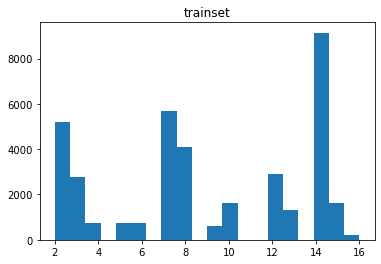

min/max : 2 16


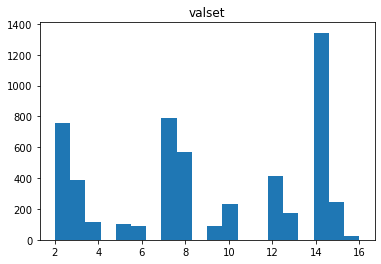

min/max : 2 16


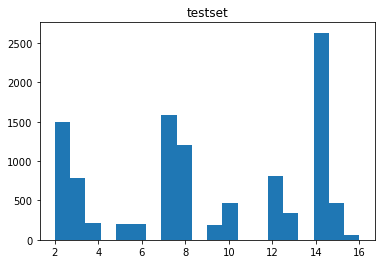

min/max : 2 16


In [93]:
def plot_histo_graphs(dataset, title):
    # histogram of graph sizes
    graph_sizes = []
    for graph in dataset:
        graph_sizes.append(graph[0].number_of_nodes())
    plt.figure(1)
    plt.hist(graph_sizes, bins=20)
    plt.title(title)
    plt.show()
    graph_sizes = torch.Tensor(graph_sizes)
    print('min/max :',graph_sizes.min().long().item(),graph_sizes.max().long().item())

plot_histo_graphs(datasetDGL.train,'trainset')
plot_histo_graphs(datasetDGL.val,'valset')
plot_histo_graphs(datasetDGL.test,'testset')

# Test

In [50]:
train[0]

{'num_node': 14,
 'node_type': tensor([0, 1, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], dtype=torch.int8),
 'adj': tensor([[0, 1, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1]], dtype=torch.int8),
 'target': tensor(6)}

In [68]:
datasetDGL.train[0][1].item()


6